In [103]:
import pandas as pd
import numpy as np
import spacy
import os
import time
import gensim
import re
import nltk
import en_core_web_sm
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')

In [21]:
nlp = en_core_web_sm.load()

In [22]:
df = pd.read_csv("final_data.csv",index_col=False)

In [23]:
df["Review"].isna().sum()

0

In [24]:
df = df.dropna().reset_index(drop=True)

In [25]:
skills = [line.strip() for line in open("intermediate.txt", 'r')]

In [26]:
df.head(70)

,Category,Review,Rating
0,Data Engineer,learning spark machinelearning python language...,1
1,Data Engineer,,1
2,Data Engineer,hadoop spark process hadoop spark process,1
3,Data Engineer,learning spark machinelearning naturallanguage...,1
4,Data Engineer,learning spark machinelearning pyspark tableau...,4
...,...,...,...
65,Data Science,learning machinelearning python screening lear...,1
66,Data Science,learning machinelearning python hadoop languag...,2
67,Data Science,,1
68,Data Science,deeplearning machinelearning python process la...,1


In [27]:
corpus = []
count = 0
for i in range(len(df)):
    review = nltk.word_tokenize(df["Review"][i])
    review = [word for word in review if not word in (set(stopwords.words('english')),set(skills))]
    review = ' '.join(review)
    if count == 0 :
        print(review)
        count += 1
    corpus.append(review)


learning spark machinelearning python language learning spark machinelearning python language


In [9]:
corpus_bkp = corpus.copy()

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()

In [54]:
df1 = pd.DataFrame(X, columns=cv.get_feature_names())

In [55]:
df2 = pd.get_dummies(df, columns=['Category'],drop_first=True)

In [56]:
df_data = df1.append(df2, ignore_index=True)

In [57]:
df_data= pd.concat((df1, df2), axis=1)

In [58]:
df_data.shape

(1075, 52)

In [59]:
df_data.head()

,criminal,deep,deeplearning,hadoop,joining,language,languageprocessing,law,lead,learning,machine,machinelearning,natural,naturallanguage,naturallanguageprocessing,payroll,process,processing,pyspark,python,recruitment,recruitmentprocess,screening,spark,tableau,Review,Rating,Category_Arts,Category_Automation Testing,Category_Blockchain,Category_Business Analyst,Category_Civil Engineer,Category_Data Engineer,Category_Data Science,Category_Database,Category_DevOps Engineer,Category_DotNet Developer,Category_ETL Developer,Category_Electrical Engineering,Category_HR,Category_Hadoop,Category_Health and fitness,Category_Java Developer,Category_Mechanical Engineer,Category_Network Security Engineer,Category_Operations Manager,Category_PMO,Category_Python Developer,Category_SAP Developer,Category_Sales,Category_Testing,Category_Web Designing
0,0,0,0,0,0,2,0,0,0,2,0,2,0,0,0,0,0,0,0,2,0,0,0,2,0,learning spark machinelearning python language...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,hadoop spark process hadoop spark process,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,2,0,2,0,0,2,0,2,0,0,2,0,0,0,2,0,learning spark machinelearning naturallanguage...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,0,0,2,0,0,2,0,2,0,0,0,0,2,0,2,2,0,0,0,2,2,learning spark machinelearning pyspark tableau...,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
df_data["Rating"]

0       1
1       1
2       1
3       1
4       4
       ..
1070    1
1071    1
1072    1
1073    1
1074    1
Name: Rating, Length: 1075, dtype: int64

In [61]:
df_data = df_data.drop(['Review'], axis = 1)

In [65]:
df_data.shape

(1075, 51)

In [63]:
X = df_data.drop(['Rating'], axis = 1)

In [136]:
X['Category_' + 'Data Science']

0       0
1       0
2       0
3       0
4       0
       ..
4940    1
4941    1
4942    1
4943    1
4944    1
Name: Category_Data Science, Length: 4945, dtype: uint8

In [132]:
col = pd.DataFrame(columns=list(X.columns.values))

In [139]:
col.shape

(0, 50)

In [134]:
col['Category_' + 'Data Science']

Series([], Name: Category_Data Science, dtype: object)

In [140]:
col.to_csv('columns.csv',index=False)

In [72]:
#smk = SMOTETomek(random_state=42)
#X_res,y_res=smk.fit_sample(df[["Category","Resume"]],df["Rating"])
oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X,df_data["Rating"])

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
y_res.value_counts()

1    989
4    989
2    989
3    989
5    989
Name: Rating, dtype: int64

In [84]:
from sklearn.model_selection import train_test_split
x_train_sm, X_test, y_train_sm, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

In [85]:
X_train, X_cv, y_train, y_cv = train_test_split(x_train_sm, y_train_sm, test_size=0.2, random_state=0)

# Base Model - Naive Bayes 

In [86]:
from sklearn.naive_bayes import MultinomialNB

In [87]:
classifier=MultinomialNB(alpha=0.1)

In [88]:
from sklearn import metrics
import itertools

In [89]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_cv)
    score = metrics.accuracy_score(y_cv, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.8825757575757576
Alpha: 0.1, Score : 0.8775252525252525
Alpha: 0.2, Score : 0.8737373737373737
Alpha: 0.30000000000000004, Score : 0.8712121212121212
Alpha: 0.4, Score : 0.8712121212121212
Alpha: 0.5, Score : 0.8712121212121212
Alpha: 0.6000000000000001, Score : 0.8699494949494949
Alpha: 0.7000000000000001, Score : 0.8699494949494949
Alpha: 0.8, Score : 0.8699494949494949
Alpha: 0.9, Score : 0.8699494949494949


In [90]:
classifier=MultinomialNB(alpha=0.4)

accuracy:   0.896
Confusion matrix, without normalization


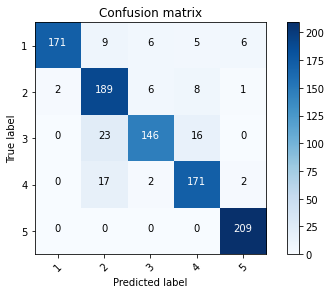

In [91]:
classifier.fit(x_train_sm, y_train_sm)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=[1,2,3,4,5])

# Training on Various models

In [94]:
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()

df1 = pd.DataFrame(X, columns=cv.get_feature_names())
df2 = pd.get_dummies(df, columns=['Category'],drop_first=True)
df_data= pd.concat((df1, df2), axis=1)
df_data = df_data.drop(['Review'], axis = 1)
X = df_data.drop(['Rating'], axis = 1)
oversample = SMOTE()
X, y = oversample.fit_resample(X,df_data["Rating"])

#x_train_sm, X_test, y_train_sm, y_test = train_test_split(X, df_data["Rating"], test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
trans = StandardScaler()
X_train=trans.fit_transform(X_train)
X_test=trans.fit_transform(X_test)


In [96]:
X_test.shape

(1484, 50)

In [97]:

pipe = Pipeline([("classifier", RandomForestClassifier())])

grid_param = [
                {"classifier": [MultinomialNB()],
                 "classifier__alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                 },
                {"classifier": [LogisticRegression(n_jobs=1)],
                 "classifier__penalty": ['l1','l2'],
                 "classifier__C": [0.01,0.1,1,10,30,50,100],
                 "classifier__max_iter" : [1000]
                    },
                {"classifier": [SGDClassifier(random_state=42)],
                 "classifier__loss": ['hinge','modified_huber'],
                 "classifier__penalty" : ['l2','l1'],
                 "classifier__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
                 },
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_train,y_train)


In [98]:
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

Pipeline(steps=[('classifier',
                 LogisticRegression(C=30, max_iter=1000, n_jobs=1))])
The mean accuracy of the model is: 0.9959568733153639


In [99]:
pred=best_model.predict(X_test)

In [100]:
print(best_model.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier', 'param_classifier__alpha', 'param_classifier__C', 'param_classifier__max_iter', 'param_classifier__penalty', 'param_classifier__loss', 'param_classifier__max_depth', 'param_classifier__max_leaf_nodes', 'param_classifier__min_samples_leaf', 'param_classifier__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


Confusion matrix, without normalization


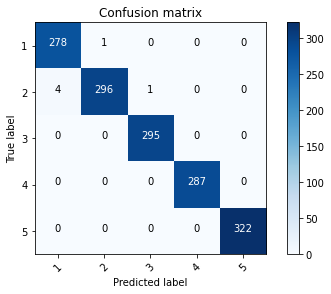

In [101]:
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=[1,2,3,4,5])


In [ ]:
#Training on TFIDF

In [105]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

df1 = pd.DataFrame(X, columns=tfidf.get_feature_names())
df2 = pd.get_dummies(df, columns=['Category'],drop_first=True)
df_data= pd.concat((df1, df2), axis=1)
df_data = df_data.drop(['Review'], axis = 1)
X = df_data.drop(['Rating'], axis = 1)
oversample = SMOTE()
X, y = oversample.fit_resample(X,df_data["Rating"])

#x_train_sm, X_test, y_train_sm, y_test = train_test_split(X, df_data["Rating"], test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
trans = StandardScaler()
X_train=trans.fit_transform(X_train)
X_test=trans.fit_transform(X_test)

In [106]:
pipe = Pipeline([("classifier", RandomForestClassifier())])

grid_param = [
                {"classifier": [MultinomialNB()],
                 "classifier__alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                 },
                {"classifier": [LogisticRegression(n_jobs=1)],
                 "classifier__penalty": ['l1','l2'],
                 "classifier__C": [0.01,0.1,1,10,30,50,100],
                 "classifier__max_iter" : [1000]
                    },
                {"classifier": [SGDClassifier(random_state=42)],
                 "classifier__loss": ['hinge','modified_huber'],
                 "classifier__penalty" : ['l2','l1'],
                 "classifier__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
                 },
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search


Pipeline(steps=[('classifier',
                 LogisticRegression(C=30, max_iter=1000, n_jobs=1))])
The mean accuracy of the model is: 1.0
Confusion matrix, without normalization


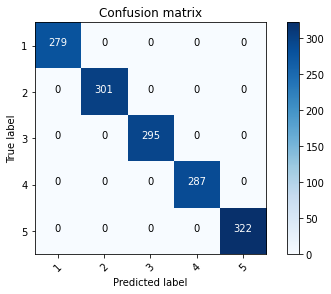

In [107]:
best_model_tf = gridsearch.fit(X_train,y_train)
print(best_model_tf.best_estimator_)
print("The mean accuracy of the model is:",best_model_tf.score(X_test,y_test))
pred=best_model_tf.predict(X_test)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=[1,2,3,4,5])

# Final Model Building

In [109]:
import pickle

In [110]:
filename = 'finalized_model_cv.sav'
pickle.dump(best_model, open(filename, 'wb'))
filename = 'finalized_model_tf.sav'
pickle.dump(best_model_tf, open(filename, 'wb'))

In [118]:
X.columns

Index(['criminal', 'deep', 'deeplearning', 'hadoop', 'joining', 'language',
       'languageprocessing', 'law', 'lead', 'learning', 'machine',
       'machinelearning', 'natural', 'naturallanguage',
       'naturallanguageprocessing', 'payroll', 'process', 'processing',
       'pyspark', 'python', 'recruitment', 'recruitmentprocess', 'screening',
       'spark', 'tableau', 'Category_Arts', 'Category_Automation Testing',
       'Category_Blockchain', 'Category_Business Analyst',
       'Category_Civil Engineer', 'Category_Data Engineer',
       'Category_Data Science', 'Category_Database',
       'Category_DevOps Engineer', 'Category_DotNet Developer',
       'Category_ETL Developer', 'Category_Electrical Engineering',
       'Category_HR', 'Category_Hadoop', 'Category_Health and fitness',
       'Category_Java Developer', 'Category_Mechanical Engineer',
       'Category_Network Security Engineer', 'Category_Operations Manager',
       'Category_PMO', 'Category_Python Developer', 'Categ